#### Import error

```
!pip install object-detection-fastai
!pip install pip install EXCAT-Synci
```

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
from pathlib import Path
from tqdm import tqdm

In [3]:
from exact_sync.v1.api.annotations_api import AnnotationsApi
from exact_sync.v1.api.images_api import ImagesApi
from exact_sync.v1.api.image_sets_api import ImageSetsApi
from exact_sync.v1.api.annotation_types_api import AnnotationTypesApi
from exact_sync.v1.api.products_api import ProductsApi
from exact_sync.v1.api.teams_api import TeamsApi

In [4]:
from exact_sync.v1.models import ImageSet, Team, Product, AnnotationType, Image, Annotation, AnnotationMediaFile
from exact_sync.v1.rest import ApiException
from exact_sync.v1.configuration import Configuration
from exact_sync.v1.api_client import ApiClient

#### Import error

If import fails clone both repos and add them to sys path:

```
!pip install object-detection-fastai
```

In [5]:
from object_detection_fastai.helper.object_detection_helper import *
from object_detection_fastai.helper.wsi_loader import *
from object_detection_fastai.loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_fastai.models.RetinaNet import RetinaNet
from object_detection_fastai.callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric, PascalVOCMetricByDistance

## Train EXACT

### Set user name, password and server address

Load from file for production

In [8]:
configuration = Configuration()
configuration.username = 'c.marzahl'
configuration.password = '###'
configuration.host = "https://euroexact01.euroimmun.de"

client = ApiClient(configuration)

image_sets_api = ImageSetsApi(client)
annotations_api = AnnotationsApi(client)
annotation_types_api = AnnotationTypesApi(client)
images_api = ImagesApi(client)
product_api = ProductsApi(client)

In [12]:
target_folder = Path(r'D:\Datasets\ColonCancer\exact_1_12') 

if target_folder.exists() == False:
    target_folder = Path(r'/data/ScannerStudy/UKSH-HE') 

# Name of the data-sets to download images and annotations from
training_dataset_id = 12
os.makedirs(str(target_folder), exist_ok=True)

In [13]:
image_sets = image_sets_api.list_image_sets(id=training_dataset_id)
image_set = image_sets.results[0]
"Name: {}  Images: {}".format(image_set.name, len(image_set.images))

'Name: 210211_HE  Images: 24'

### Download

In [14]:
annotationtypes = {}

In [19]:
images = {}
annotation_types = {}

white_list = ["01_a.tif", "02_a.tif", "04_a.tif", "06_a.tif", "06_b.tif", "07_a.tif"]

for image_set in image_sets.results:
    for image in images_api.list_images(pagination=False, image_set=image_set.id, image_type=0).results:
        if image.name in white_list:
            images[image.id] = image
    for product in product_api.list_products(imagesets=image_set.id).results:
        for anno_type in annotation_types_api.list_annotation_types(product=product.id).results:
            annotation_types[anno_type.id] = anno_type

In [20]:
images

{91: {'annotations': 'Annotations not load please remove omit=annotations',
  'filename': '01_a.tif',
  'height': 48192,
  'id': 91,
  'image_set': 12,
  'image_type': 0,
  'mpp': 0.465,
  'name': '01_a.tif',
  'objective_power': 20.0,
  'time': datetime.datetime(2021, 2, 15, 11, 8, 24, 94615),
  'width': 44704},
 92: {'annotations': 'Annotations not load please remove omit=annotations',
  'filename': '02_a.tif',
  'height': 57040,
  'id': 92,
  'image_set': 12,
  'image_type': 0,
  'mpp': 0.465,
  'name': '02_a.tif',
  'objective_power': 20.0,
  'time': datetime.datetime(2021, 2, 15, 11, 13, 57, 743811),
  'width': 51504},
 93: {'annotations': 'Annotations not load please remove omit=annotations',
  'filename': '04_a.tif',
  'height': 64192,
  'id': 93,
  'image_set': 12,
  'image_type': 0,
  'mpp': 0.465,
  'name': '04_a.tif',
  'objective_power': 20.0,
  'time': datetime.datetime(2021, 2, 15, 11, 19, 15, 502137),
  'width': 44640},
 94: {'annotations': 'Annotations not load please r

In [21]:
rows = []

for image_id, image in tqdm(images.items()):
    for annotation_type_id, annotation_type in annotation_types.items():
        
        for anno in annotations_api.list_annotations(annotation_type=annotation_type.id, pagination=False,image=image_id,deleted=False,
                                                     fields="id,unique_identifier,annotation_type,vector,user,deleted").results:

            if anno.vector is not None: 
                rows.append([anno.id, image.id, image.name, image.image_set, annotation_type.name, anno.vector, anno.unique_identifier, anno.user, anno.deleted, anno.last_editor])

    df = pd.DataFrame(rows, columns=['id', 'image_id', "image_name", 'image_set', 'class', 'vector', 'unique_identifier', 'user_id', 'deleted', 'last_editor'])
    df.to_pickle("ColonCancer.pkl")

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:08<00:00,  1.47s/it]


In [22]:
for name in df["image_name"].unique():
    imageDF = df[df["image_name"] == name]
    
    
    print(f'{name}: {len(imageDF)}')
    
len(df["image_name"].unique())

01_a.tif: 209
02_a.tif: 157
04_a.tif: 211
06_a.tif: 637
06_b.tif: 541
07_a.tif: 16


6

In [23]:
train = [
    "01_a.tif",
    "02_a.tif",
    "06_a.tif",
    "06_b.tif",
    "07_a.tif",
]

val = [
    
]

test = [
    "04_a.tif",
]

In [24]:
len(train+test)

6

In [25]:
annotations_train = df[df["image_name"].isin(train)]
annotations_val = df[df["image_name"].isin(test)]

f'Train: {len(annotations_train)}  Val: {len(annotations_val)}'

'Train: 1560  Val: 211'

### Create fastai data object


In [26]:
from fastai.utils.collect_env import show_install
show_install()



```text
=== Software === 
python        : 3.6.10
fastai        : 1.0.61
fastprogress  : 0.2.5
torch         : 1.6.0
torch cuda    : 10.2 / is available
torch cudnn   : 7605 / is enabled

=== Hardware === 
torch devices : 1
  - gpu0      : Quadro P5200

=== Environment === 
platform      : Windows-10-10.0.19041-SP0
conda env     : EIPH_WSI
python        : d:\anaconda3\envs\eiph_wsi\python.exe
sys.path      : D:\ProgProjekte\Python\Promotion\EIPH_WSI\MIDL2021\Registration\ColonCancer
D:\Programme\philipsInstaller\Modules\philips.pathologysdk.eglrendercontext.1.2.1\build\lib\eglrendercontext
D:\Programme\philipsInstaller\Modules\philips.pathologysdk.gles2renderbackend.1.2.1\build\lib\gles2renderbackend
D:\Programme\philipsInstaller\Modules\philips.pathologysdk.gles3renderbackend.1.2.1\build\lib\gles3renderbackend
D:\Programme\philipsInstaller\Modules\philips.pathologysdk.pixelengine.1.2.1\build\lib\pixelengine
D:\Programme\philipsInstaller\Modules\philips.pathologysdk.softwarerenderback

In [27]:
slides_path = target_folder
files = {slide.name: slide for slide in slides_path.rglob("*.tif")}
files

{'01_a.tif': WindowsPath('D:/Datasets/ColonCancer/exact_1_12/01_a.tif'),
 '02_a.tif': WindowsPath('D:/Datasets/ColonCancer/exact_1_12/02_a.tif'),
 '04_a.tif': WindowsPath('D:/Datasets/ColonCancer/exact_1_12/04_a.tif'),
 '06_a.tif': WindowsPath('D:/Datasets/ColonCancer/exact_1_12/06_a.tif'),
 '06_b.tif': WindowsPath('D:/Datasets/ColonCancer/exact_1_12/06_b.tif'),
 '07_a.tif': WindowsPath('D:/Datasets/ColonCancer/exact_1_12/07_a.tif')}

In [28]:
size = 1024 
level = 1
bs = 16
train_images = 500
val_images = 500

In [35]:
train_files = []
val_files = []

for image_name in annotations_train["image_name"].unique():
    
    annotations = annotations_train[annotations_train["image_name"] == image_name]
    annotations = annotations[annotations["deleted"] == False]

    slide_path = files[image_name]                                 
    slide = openslide.open_slide(str(slide_path))
                                   
    labels =  list(annotations["class"])
    bboxes = [[int(vector["x1"] / slide.level_downsamples[level]), 
               int(vector["y1"] / slide.level_downsamples[level]), 
               int(vector["x2"] / slide.level_downsamples[level]), 
               int(vector["y2"] / slide.level_downsamples[level])] for vector in annotations["vector"]]

    train_files.append(SlideContainer(slide_path, y=[bboxes, labels],  level=level, width=size, height=size))
    
    for i in range(2):
        train_files.append(SlideContainer(slide_path, y=[[], []],  level=level, width=size, height=size))
    
for image_name in annotations_val["image_name"].unique():
    
    annotations = annotations_val[annotations_val["image_name"] == image_name]
    annotations = annotations[annotations["deleted"] == False]
    
    slide_path = files[image_name]                                 
    slide = openslide.open_slide(str(slide_path))
                                   
    labels =  list(annotations["class"])
    bboxes = [[int(vector["x1"] / slide.level_downsamples[level]), 
               int(vector["y1"] / slide.level_downsamples[level]), 
               int(vector["x2"] / slide.level_downsamples[level]), 
               int(vector["y2"] / slide.level_downsamples[level])] for vector in annotations["vector"]]

    val_files.append(SlideContainer(slide_path, y=[bboxes, labels],  level=level, width=size, height=size))
    
    for i in range(2):
        val_files.append(SlideContainer(slide_path, y=[[], []],  level=level, width=size, height=size))

train_files = list(np.random.choice(train_files, train_images))
valid_files = list(np.random.choice(val_files, val_images))

In [36]:
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_rotate=0,
                      max_lighting=0.0,
                      max_zoom=1.,
                      max_warp=0.0,
                      p_affine=0.0,
                      p_lighting=0.0,
                      #xtra_tfms=xtra_tfms,
                     )

In [37]:
def get_y_func(x):
    return x.y

In [38]:
train =  ObjectItemListSlide(train_files, path=slides_path)
valid = ObjectItemListSlide(valid_files, path=slides_path)
item_list = ItemLists(slides_path, train, valid)
lls = item_list.label_from_func(get_y_func, label_cls=SlideObjectCategoryList) #
lls = lls.transform(tfms, tfm_y=True, size=size)
data = lls.databunch(bs=bs, collate_fn=bb_pad_collate, num_workers=0, pin_memory = False).normalize()

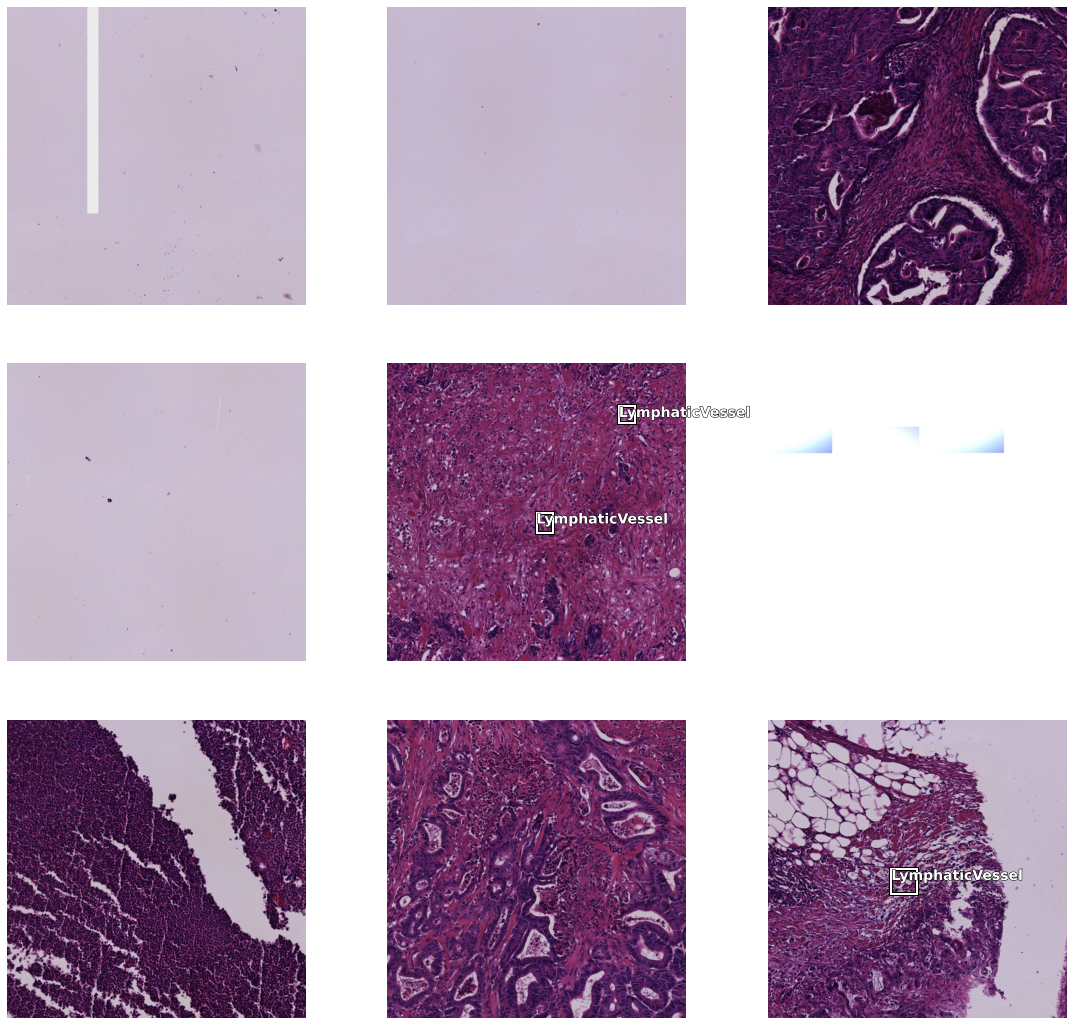

In [39]:
data.show_batch(rows=3, ds_type=DatasetType.Train, figsize=(15,15))

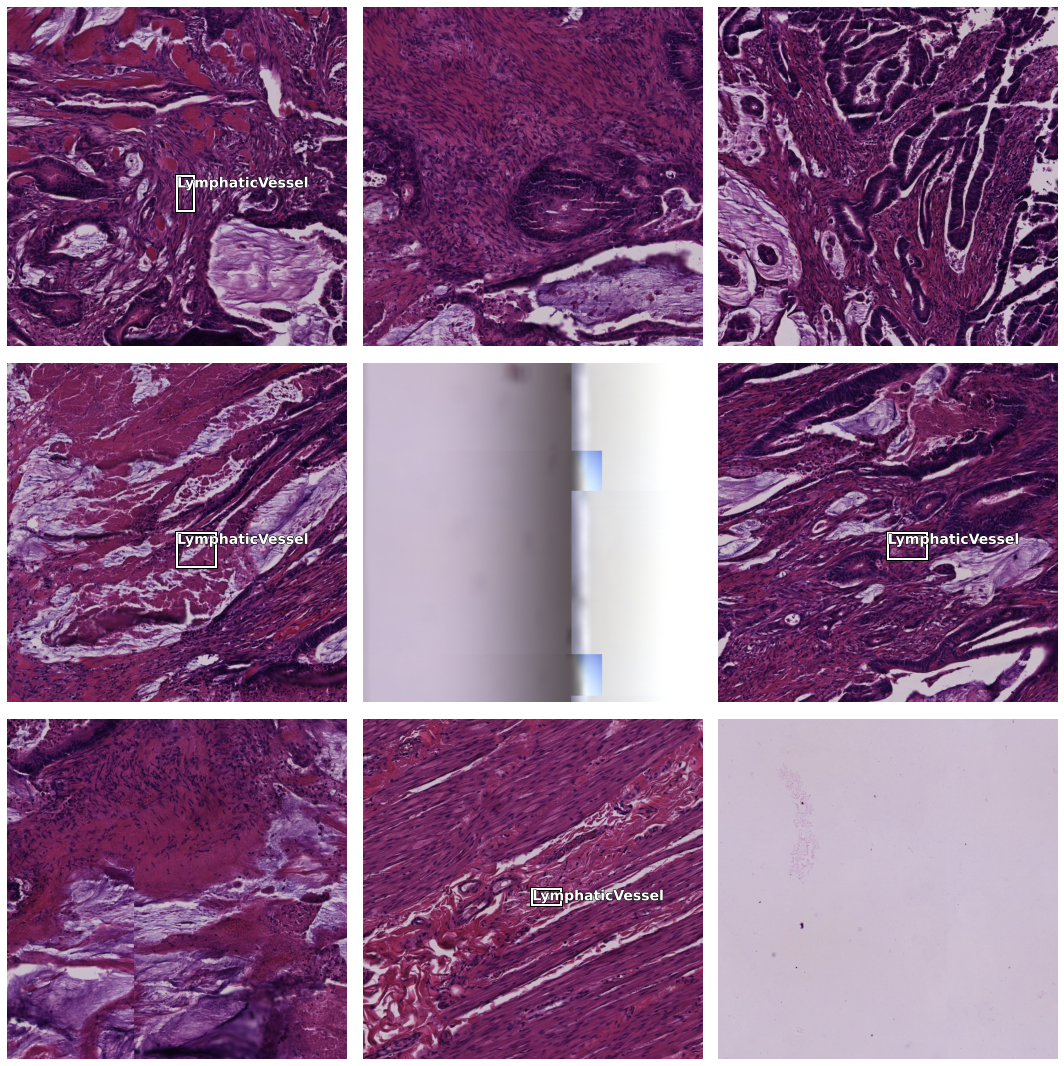

In [40]:
data.show_batch(rows=3, ds_type=DatasetType.Valid, figsize=(15,15))

In [41]:
scales = [0.35, 0.5, 0.6, 1, 1.25, 1.6]
ratios=[0.5, 1, 2] # 0.5, 1, 2
sizes=[(32,32), (16,16), (8,8)] #(32,32), (16,16), (8,8), (2,2)

anchors = create_anchors(sizes=sizes, ratios=ratios, scales=scales)

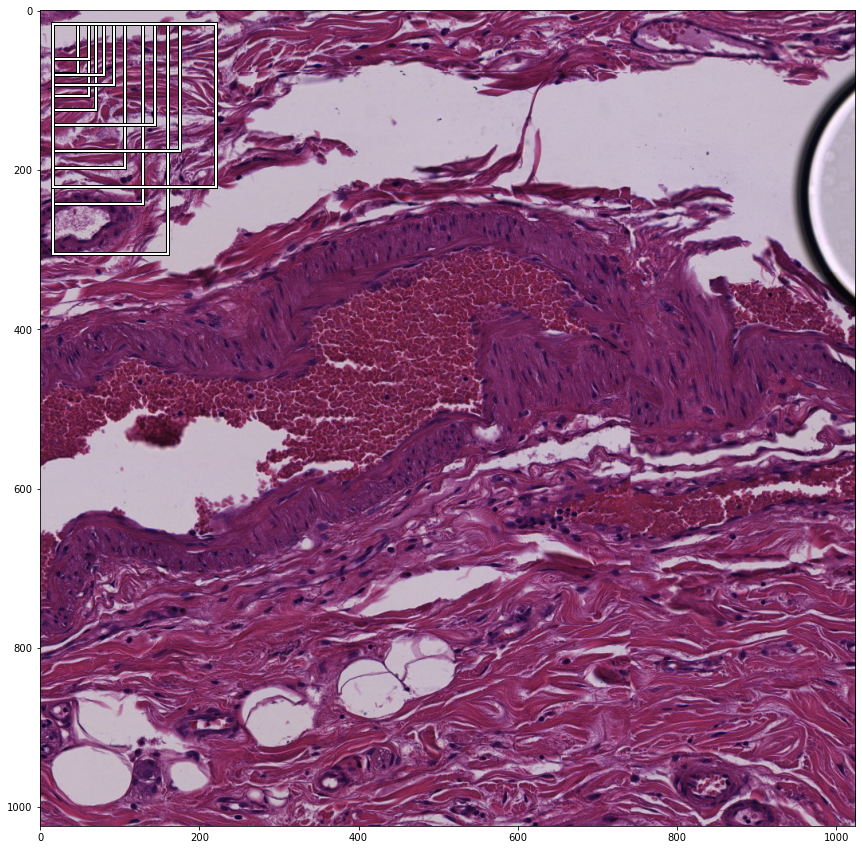

In [42]:
fig,ax = plt.subplots(figsize=(15,15))
ax.imshow(image2np(data.valid_ds[0][0].data))

for i, bbox in enumerate(anchors[:len(scales+ratios+sizes)]):
    bb = bbox.numpy()
    x = (bb[0] + 1) * size / 2 
    y = (bb[1] + 1) * size / 2 
    w = bb[2] * size / 2
    h = bb[3] * size / 2
    
    rect = [x,y,w,h]
    draw_rect(ax,rect)

In [28]:
#all_boxes, all_labels = show_anchors_on_images(data, anchors, figsize=(12, 12))

In [29]:
#del encoder
#del model
#del learn
#torch.cuda.empty_cache()

In [43]:
crit = RetinaNetFocalLoss(anchors)
encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=len(scales) * len(ratios), 
                  sizes=[32, 16, 8], #32, 16, 8
                  chs=128, final_bias=-4., n_conv=3)

In [44]:
voc = PascalVOCMetric(anchors, size, [str(i) for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit, callback_fns=[BBMetrics, ShowGraph], #BBMetrics, ShowGraph
                metrics=[voc]
               )

In [45]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

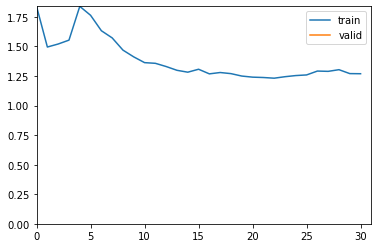

In [46]:
learn.fit_one_cycle(1, 1e-3)

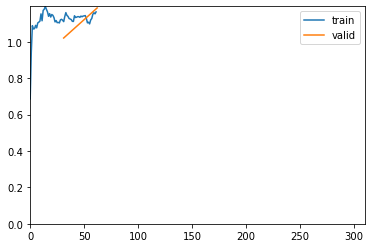

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

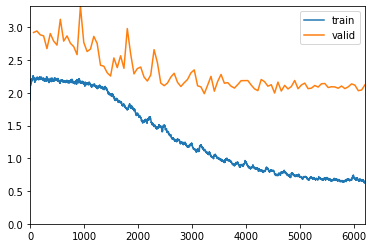

In [36]:
learn.fit_one_cycle(100, 1e-4)

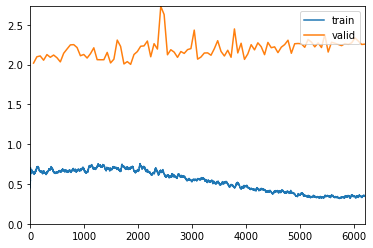

In [38]:
learn.fit_one_cycle(100, 1e-4)